# Flu Shot Learning

To do
- explore the data
- aoc curve, analysis etc
- explore categoricals with skl
- try many different models
- learning curves
- why AUC and not max difference between curve and linear?

## Load modules and data

In [117]:
# Fundamental
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr as corr

In [15]:
dfx = pd.read_csv('training_set_features.csv')
yall = pd.read_csv('training_set_labels.csv').values[:,1:] # First col = h1n1, second - seasonal.
feats = list(dfx.columns)

## Initial (unfitted) preprocessing

In [11]:
dfx['age_group'].unique()

array(['55 - 64 Years', '35 - 44 Years', '18 - 34 Years', '65+ Years',
       '45 - 54 Years'], dtype=object)

In [12]:
def initial_processing(df):
    df['age_num'] = 0
    df.loc[df['age_group'] == '18 - 34 Years','age_num'] = (34-18)/2
    df.loc[df['age_group'] == '35 - 44 Years','age_num'] = (44-35)/2
    df.loc[df['age_group'] == '45 - 54 Years','age_num'] = (54-45)/2
    df.loc[df['age_group'] == '55 - 64 Years','age_num'] = (64-55)/2
    df.loc[df['age_group'] == '65+ Years','age_num']     = 70
    if 'respondent_id' in df.columns:
        df.drop(columns=['respondent_id'],inplace=True)

In [13]:
initial_processing(dfx)

## Data exploration

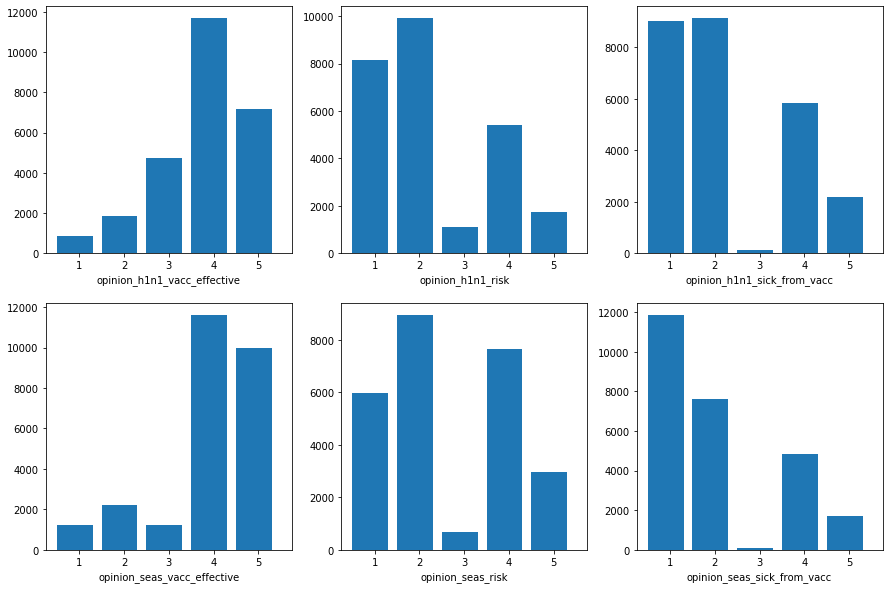

In [16]:
fig, axes = plt.subplots(figsize = (15, 10), ncols=3, nrows=2)
axeslist = [axes[0,i] for i in range(3)] + [axes[1,i] for i in range(3)]

i=0
for thing in feats:
    if 'opinion' in thing:
        dfx[thing].hist(ax = axeslist[i], bins=[0.5,1.5,2.5,3.5,4.5,5.5], grid=False, width=0.8)
        axeslist[i].set_xlabel(thing)
        i+=1
plt.show()

## Create objects for fitted preprocessing

Here we make a function to scale the axes independently, instead of using a transformation pipeline. This is to allow more flexibility when performing feature engineering.

In [20]:
num_cols = list(dfx.columns[dfx.dtypes != object])
cat_cols = list(dfx.columns[dfx.dtypes == object])

#### Existing transformers
Here we make pipes using built-in transformers.

In [21]:
numerical_processing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('mmscal', MinMaxScaler())
])

categorical_processing = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

#### Custom transformers / pipelines

In [105]:
class WeightedOpinions(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if 'opinion' in col:
                X[col] = (X[col]-3)**3 # 3 is the mid-point. Raise to an odd-power to preserve monotonicity.
        return X
    
extra_processing = Pipeline([
    ('wo', WeightedOpinions()),
    ('imputer', SimpleImputer(strategy='median')),
    ('mmscal', MinMaxScaler())
])

#### Combine into ColumnTransformer

In [106]:
preprocessor = ColumnTransformer(
    transformers = [
    ('ext', extra_processing, num_cols),
    ('num', numerical_processing, num_cols),
    ('cat', categorical_processing, cat_cols)
    ], 
    remainder='drop')

## Define models

In [120]:
global_max_iter = 600

model_logreg_l1 = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=global_max_iter)
)

model_logreg_l2 = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=global_max_iter)
)

model_logreg_elastic = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='elasticnet', C=1, solver='saga', max_iter=global_max_iter, l1_ratio = 0.5)
)

model_rf = MultiOutputClassifier(
    estimator=RandomForestClassifier(max_depth = 10)
)

model_cat = MultiOutputClassifier(
    estimator=CatBoostClassifier()
)

dict_of_models = {
    'logred_l1':model_logreg_l1,
    'logred_l2':model_logreg_l2,
    'logreg_elastic':model_logreg_elastic,
    'rf':model_rf,
    'cat':model_cat,
}

## Define output translation functions

In [108]:
def transform_MOC_output(arrin):
    h1n1_probs = arrin[0][:,1]
    seas_probs = arrin[1][:,1]
    return np.stack([h1n1_probs, seas_probs]).T

## Create train/test split

In [109]:
dfxtr, dfxcv, ytr, ycv = train_test_split(
    dfx,
    yall,
    test_size=0.33,
    shuffle=True,
    stratify=yall,
    random_state=6
)

## Fit and test models

#### Process

In [110]:
xtr = preprocessor.fit_transform(dfxtr)
xcv = preprocessor.transform(dfxcv)

In [121]:
models_to_test = dict_of_models.keys() # Can change to a subset
models_to_test = ['logred_l1', 'cat']

#### Fit

In [122]:
for modelname in models_to_test:
    model = dict_of_models[modelname]
    model.fit(xtr, ytr);
    print('Model {} fit complete'.format(modelname))

Model logred_l1 fit complete
Learning rate set to 0.035304
0:	learn: 0.6679387	total: 115ms	remaining: 1m 55s
1:	learn: 0.6454116	total: 133ms	remaining: 1m 6s
2:	learn: 0.6250172	total: 151ms	remaining: 50.1s
3:	learn: 0.6050542	total: 171ms	remaining: 42.6s
4:	learn: 0.5879410	total: 214ms	remaining: 42.6s
5:	learn: 0.5718113	total: 235ms	remaining: 38.9s
6:	learn: 0.5572186	total: 252ms	remaining: 35.8s
7:	learn: 0.5439410	total: 270ms	remaining: 33.5s
8:	learn: 0.5315451	total: 288ms	remaining: 31.7s
9:	learn: 0.5209364	total: 312ms	remaining: 30.8s
10:	learn: 0.5107528	total: 341ms	remaining: 30.6s
11:	learn: 0.5011871	total: 360ms	remaining: 29.6s
12:	learn: 0.4920978	total: 386ms	remaining: 29.3s
13:	learn: 0.4839015	total: 418ms	remaining: 29.4s
14:	learn: 0.4767344	total: 436ms	remaining: 28.6s
15:	learn: 0.4701111	total: 457ms	remaining: 28.1s
16:	learn: 0.4639698	total: 474ms	remaining: 27.4s
17:	learn: 0.4585641	total: 492ms	remaining: 26.8s
18:	learn: 0.4532226	total: 509m

#### Test

In [123]:
dict_of_ypr = {}
dict_of_auc = {}

for modelname in models_to_test:
    model = dict_of_models[modelname]
    ypr = transform_MOC_output(model.predict_proba(xcv))
    dict_of_ypr[modelname] = ypr
    dict_of_auc[modelname] = roc_auc_score(ycv, ypr)

In [124]:
[(x, dict_of_auc[x]) for x in sorted(dict_of_auc)]

[('cat', 0.8501196052864619), ('logred_l1', 0.8456746888995886)]

#### Plot ROC

In [205]:
def plot_roc(dict_of_ypr, label):
    def subroutine(y_true, y_score, label_name, ax):
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_ylabel('TPR')
        ax.set_xlabel('FPR')
        ax.set_title(
            f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
        )

    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    ypr = dict_of_ypr[label]
    
    subroutine(
        ycv[:,0], 
        ypr[:,0], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    subroutine(
        ycv[:,1], 
        ypr[:,1], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    return None

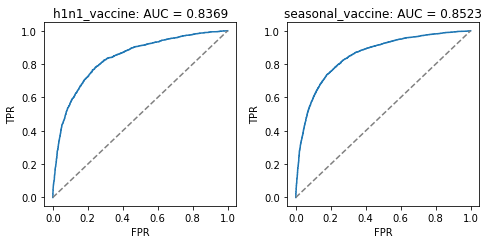

In [206]:
plot_roc(dict_of_ypr,'logred_l2')

# Speculative analysis

In [97]:
def test_param_range(paramname, min_, max_, skip=1, **kwargs):
    if paramname in kwargs.keys():
        print('Looping parameter already in kwargs!')
        return
    
    auclist_tr = []
    auclist_cv = []

    for pval in np.arange(min_, max_+1, skip):
        kwargs.update({paramname: pval})
        model = MultiOutputClassifier(estimator=RandomForestClassifier(**kwargs))
        model.fit(xtr, ytr);

        ytr_pr = transform_MOC_output(model.predict_proba(xtr))
        ycv_pr = transform_MOC_output(model.predict_proba(xcv))

        auclist_tr.append(roc_auc_score(ytr, ytr_pr))
        auclist_cv.append(roc_auc_score(ycv, ycv_pr))
    
    plt.plot(list(np.arange(min_, max_+1, skip)), auclist_tr, label='Training')
    plt.plot(list(np.arange(min_, max_+1, skip)), auclist_cv, label='Cross-val')
    plt.legend()
    plt.show()
    return

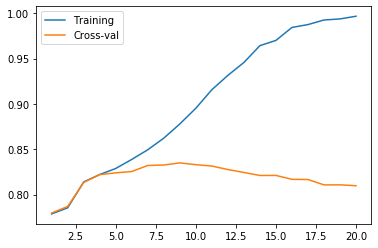

In [85]:
test_param_range('max_depth', 1, 20)

Increasing the max depth peaks the testing auc at around 8.

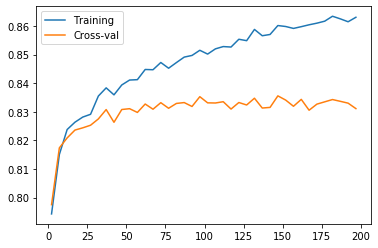

In [94]:
test_param_range('max_leaf_nodes', 2, 200, 5, max_depth=8)

## Produce labels for submission

In [125]:
df_test = pd.read_csv('test_set_features.csv')
sub_format = pd.read_csv('submission_format.csv',index_col='respondent_id')

In [126]:
initial_processing(df_test)
xte = preprocessor.transform(df_test)
ytepr = transform_MOC_output(model_cat.predict_proba(xte))

In [128]:
sub_format['h1n1_vaccine'] = ytepr[:,0]
sub_format['seasonal_vaccine'] = ytepr[:,1]

In [131]:
sub_format.to_csv('flu_sub_090520_01.csv', index=True)

## Current results

logred_l1, 0.8457386324723919

logred_l2, 0.8456195466077017

logreg_elastic, 0.8457178020021137

rf01 0.8010941751261782

cat 0.8501196052864619